## This project analyzes real apartment listings in Tehran (~4000 records) to predict house prices using machine learning. We clean the data, engineer features, and train regression models to evaluate price prediction performance.

Improt Libraries

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

## Load and Explore the Dataset
We start by loading the dataset and inspecting the structure, types, and any missing values.

In [769]:
df = pd.read_csv("1632300362534233.csv")
# take a look at the dataset
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [770]:
#Get Deep copy from data frame to compare with new data frames 
original_df = df.copy()

## Data Exploration

In [771]:
# summarize the data
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [772]:
# Check data types
print(df.dtypes)
print("\n")
print(df.isnull().sum()) # Check null values
print("\n")
print(df["Address"].value_counts())

Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object


Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64


Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                141
Shahran                   130
                         ... 
Chardangeh                  1
Mehrabad                    1
Pakdasht KhatunAbad         1
Kazemabad                   1
Yakhchiabad                 1
Name: count, Length: 192, dtype: int64


## Visualize Distributions and Detect Outliers

Here we use histograms and boxplots to understand the distribution of key features like Area, Price, Room, Parking, etc. This helps identify outliers and skewed values.

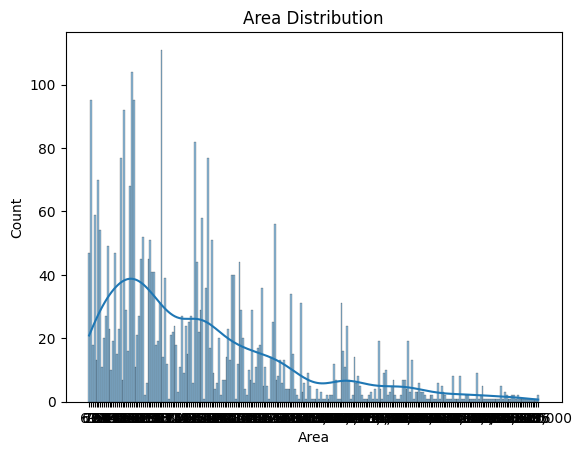

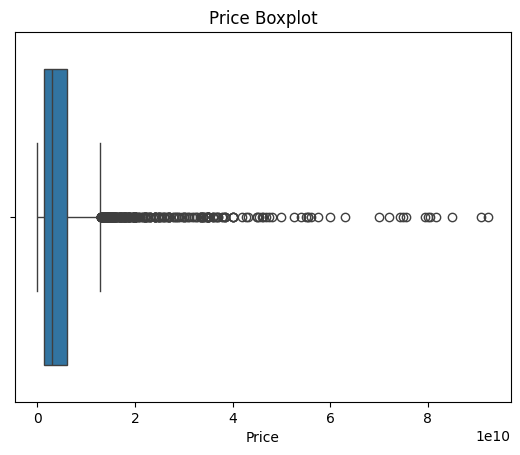

In [773]:
sns.histplot(df["Area"], kde=True)
plt.title("Area Distribution")
plt.show()

sns.boxplot(x=df["Price"])
plt.title("Price Boxplot")
plt.show()

## Check which Features(columns) effect price

In [774]:
print(df.groupby("Warehouse")["Price"].mean())
print(df.groupby("Parking")["Price"].mean())
print(df.groupby("Elevator")["Price"].mean())
print(df.groupby("Room")["Price"].mean())

Warehouse
False    2.459829e+09
True     5.629626e+09
Name: Price, dtype: float64
Parking
False    1.723625e+09
True     6.010930e+09
Name: Price, dtype: float64
Elevator
False    3.622563e+09
True     5.828165e+09
Name: Price, dtype: float64
Room
0    7.860500e+09
1    1.703751e+09
2    3.322727e+09
3    1.092580e+10
4    2.560033e+10
5    3.373439e+10
Name: Price, dtype: float64


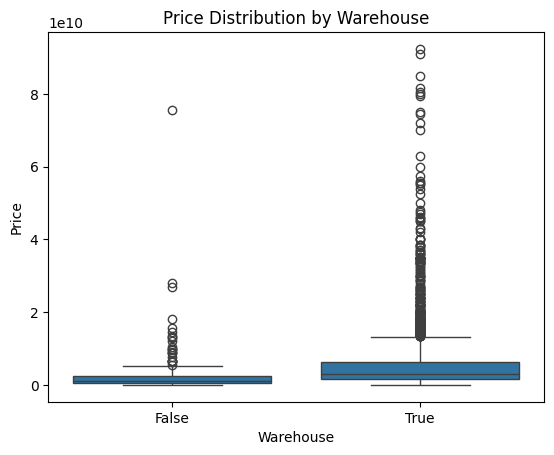

In [775]:
sns.boxplot(x="Warehouse", y="Price", data=df)
plt.title("Price Distribution by Warehouse")
plt.show()

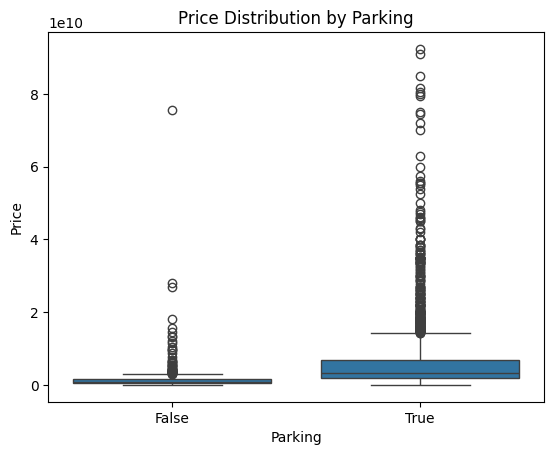

In [776]:
sns.boxplot(x="Parking", y="Price", data=df)
plt.title("Price Distribution by Parking")
plt.show()

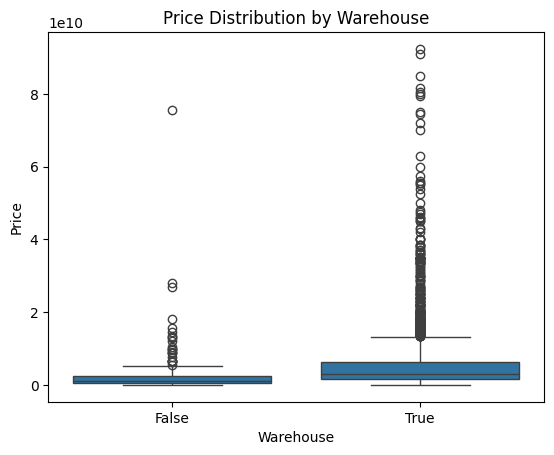

In [777]:
sns.boxplot(x="Warehouse", y="Price", data=df)
plt.title("Price Distribution by Warehouse")
plt.show()

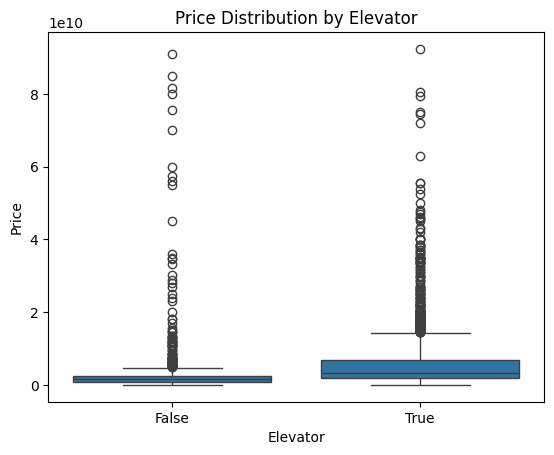

In [778]:
sns.boxplot(x="Elevator", y="Price", data=df)
plt.title("Price Distribution by Elevator")
plt.show()

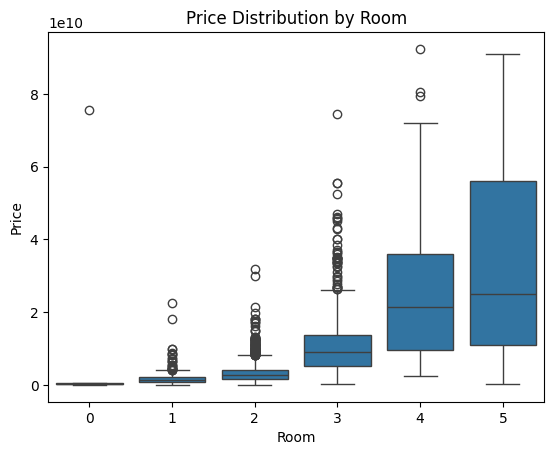

In [779]:
sns.boxplot(x="Room", y="Price", data=df)
plt.title("Price Distribution by Room")
plt.show()

## Data Cleaning And Encoding

In [780]:
df = df.dropna(subset=["Address"]) #Removing null address
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price         0
Price(USD)    0
dtype: int64

In [781]:
#Classification Addresses 
address_counts = df["Address"].value_counts()
valid_addresses = address_counts[address_counts >= 10].index
df["Frequent_Address"] = df["Address"].apply(lambda x: 1 if x in valid_addresses else 0)
df["Other_Address"] = df["Frequent_Address"].apply(lambda x: 0 if x == 1 else 1)

In [782]:
#Change Area Data type from string to float
df["Area"] = df["Area"].astype(str).str.replace(",", "").str.strip()
df["Area"] = pd.to_numeric(df["Area"], errors="coerce") 
df = df.dropna(subset=["Area"])  
df["Area"] = df["Area"].astype(float) 
#Removing Areas which are more than 500
df = df[df["Area"] < 500]

In [783]:
lower_bound = df["Price"].quantile(0.01)
upper_bound = df["Price"].quantile(0.99)
df = df[(df["Price"] >= lower_bound) & (df["Price"] <= upper_bound)]

## Check Original and Filterd Price and visualized them

In [784]:
print("Original Price Summary:")
print(original_df["Price"].describe())

print("\nFiltered Price Summary:")
print(df["Price"].describe())

Original Price Summary:
count    3.479000e+03
mean     5.359023e+09
std      8.099935e+09
min      3.600000e+06
25%      1.418250e+09
50%      2.900000e+09
75%      6.000000e+09
max      9.240000e+10
Name: Price, dtype: float64

Filtered Price Summary:
count    3.366000e+03
mean     4.759128e+09
std      5.536109e+09
min      2.950000e+08
25%      1.440500e+09
50%      2.850000e+09
75%      5.850000e+09
max      3.666000e+10
Name: Price, dtype: float64


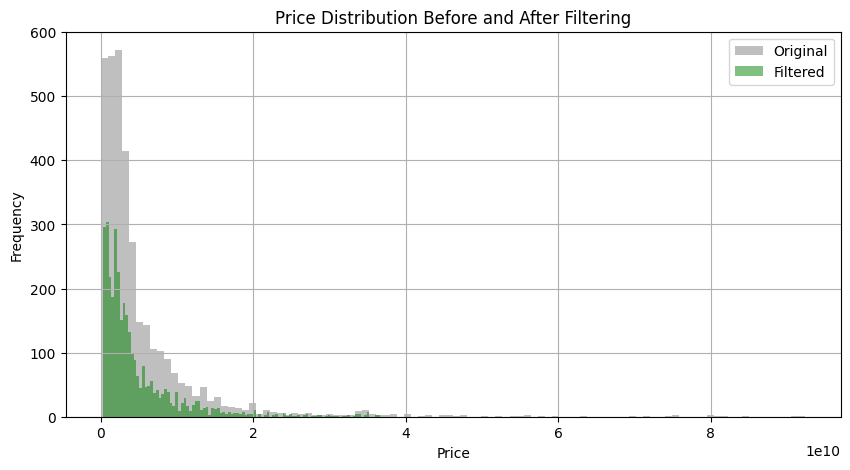

In [785]:
plt.figure(figsize=(10,5))
plt.hist(original_df["Price"], bins=100, alpha=0.5, label="Original", color='gray')
plt.hist(df["Price"], bins=100, alpha=0.5, label="Filtered", color='green')
plt.legend()
plt.title("Price Distribution Before and After Filtering")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Check Original and Filterd Area and visualized them

In [786]:
print("Original Area Summary:")
print(original_df["Area"].describe())

print("\nFiltered Area Summary:")
print(df["Area"].describe())

Original Area Summary:
count     3479
unique     243
top         75
freq       111
Name: Area, dtype: object

Filtered Area Summary:
count    3366.000000
mean      101.707962
std        49.649703
min        30.000000
25%        68.000000
50%        90.000000
75%       120.000000
max       465.000000
Name: Area, dtype: float64


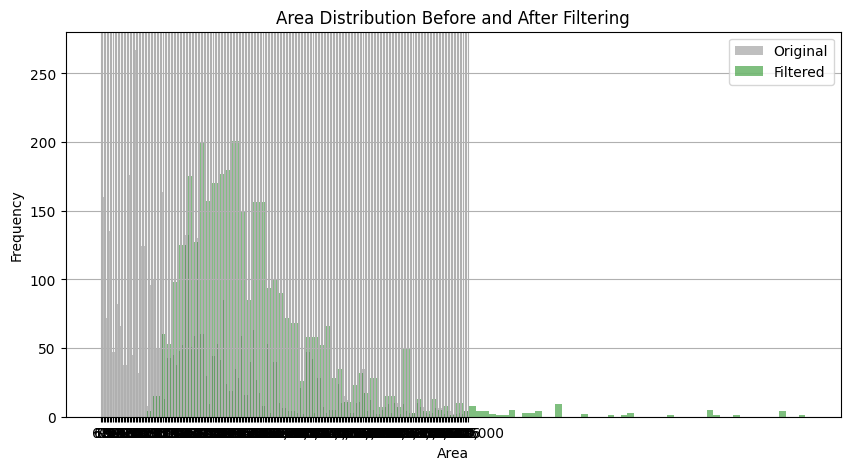

In [787]:
plt.figure(figsize=(10,5))
plt.hist(original_df["Area"], bins=100, alpha=0.5, label="Original", color='gray')
plt.hist(df["Area"], bins=100, alpha=0.5, label="Filtered", color='green')
plt.legend()
plt.title("Area Distribution Before and After Filtering")
plt.xlabel("Area")
plt.ylabel("Frequency")
plt.grid(True)
plt.show() 

## Check Address and Filterd Address and visualized them

In [788]:
#! Count original unique addresses before classification
original_unique_addresses = original_df["Address"].nunique()

#! Count how many addresses were considered "frequent"
frequent_count = df["Frequent_Address"].sum()

#! Count how many were considered "other"
other_count = df["Other_Address"].sum()

#! Count how many unique addresses were marked as frequent
valid_frequent_unique_addresses = len(valid_addresses)

print("Original Unique Addresses:", original_unique_addresses)
print("Unique Frequent Addresses:", valid_frequent_unique_addresses)
print("Total Rows in df:", len(df))
print("Frequent Rows:", frequent_count)
print("Other Rows:", other_count)
print("Sum Frequent + Other:", frequent_count + other_count)

Original Unique Addresses: 192
Unique Frequent Addresses: 68
Total Rows in df: 3366
Frequent Rows: 2989
Other Rows: 377
Sum Frequent + Other: 3366


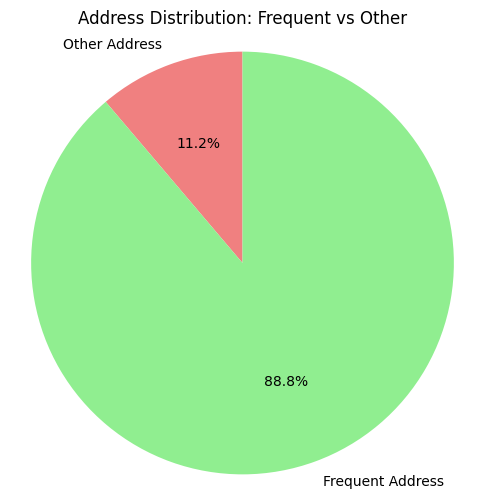

In [789]:
address_distribution = df["Frequent_Address"].value_counts().sort_index()
labels = ["Other Address", "Frequent Address"]
# Plot
plt.figure(figsize=(6, 6))
plt.pie(address_distribution, labels=labels, autopct='%1.1f%%', startangle=90, colors=["lightcoral", "lightgreen"])
plt.title("Address Distribution: Frequent vs Other")
plt.axis("equal")  
plt.show()

## Encode Boolean columns (True/False → 1/0)

In [790]:
bool_cols = ["Parking", "Warehouse", "Elevator"]
df[bool_cols] = df[bool_cols].astype(int)

## Adding Some Features to Increase R2

In [791]:
df["Elevator_Area"] = df["Elevator"] * df["Area"]
df["Room_Parking"] = df["Room"] * df["Parking"]
df["Room_Warehouse"] = df["Room"] * df["Warehouse"]
df["Combined_Facilities"] = df["Elevator"] + df["Warehouse"] + df["Parking"]
#df["Price_per_sqm"] = df["Price"] / df["Area"] Avoid of Data Leak
df["Facilities_Score"] = df["Parking"] * 2 + df["Warehouse"] + df["Elevator"] * 1.5
df["Is_Luxury"] = ((df["Area"] > 200) & (df["Facilities_Score"] > 3)).astype(int)
df["Room_Facility_Combo"] = df["Room"] * df["Facilities_Score"]
df["Room_per_Area"] = df["Room"] / df["Area"]
df["Floor_Score"] = df["Elevator"] * df["Room"]
df["Has_All_Facilities"] = ((df["Parking"] == 1) & (df["Warehouse"] == 1) & (df["Elevator"] == 1)).astype(int)

## Train And Test

In [792]:
# Choosing features and Targets
X = df.drop(columns=["Price", "Price(USD)", "Address",])
y = df["Price"]  

In [793]:
#Scale(Normalization) Not Need for RandomForest
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#poly = PolynomialFeatures(degree=2, include_bias=False)
#X_poly = poly.fit_transform(X_scaled)

In [794]:
# Explict train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [795]:
#Train Model 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

## Evaluation

In [796]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R² Score:", round(r2, 4))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

R² Score: 0.704
MAE: 1730164047.96
RMSE: 2722517842.03


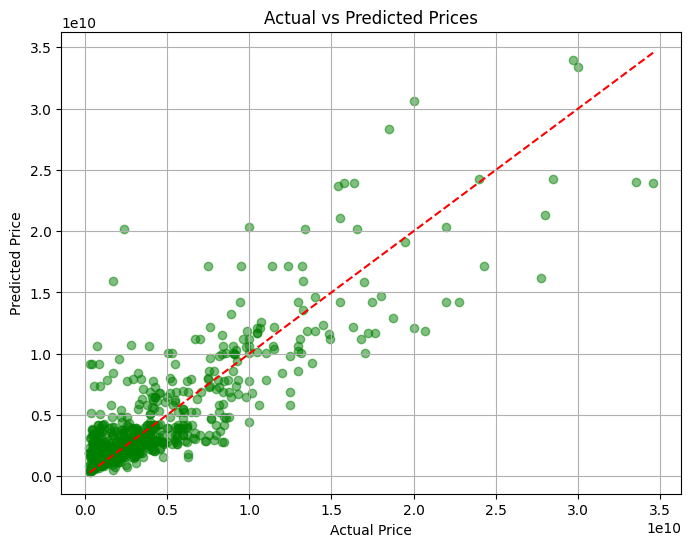

In [797]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()